In [3]:
# pip install svgpath2mpl svgpathtools
# !pip install numba

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 27.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 60.9 MB/s eta 0:00:00:00:0100:01


In [1]:
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import logging
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import interp1d
from sklearn.neighbors import NearestNeighbors
from numba import jit
from scipy import sparse
import pandas as pd

In [2]:
df = pd.read_csv('combined_peaks_named.csv')
df.describe()

,peak_area,RT1_center,RT2_center,RT1_start,RT2_start,RT1_end,RT2_end,m/z,class
count,8.640000e+02,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000,864.000000
mean,7.295166e+05,7280.061889,1.527361,7279.895611,1.556528,7281.432667,1.494111,194.075231,0.658565
std,2.471182e+06,2000.966258,0.425301,2000.837822,0.432232,2001.059576,0.418226,106.740750,0.474466
min,1.501200e+04,2953.360000,1.008000,2953.360000,1.024000,2953.360000,0.976000,30.000000,0.000000
25%,6.932407e+04,5987.824000,1.176000,5987.824000,1.200000,5987.824000,1.144000,116.000000,0.000000
50%,2.107435e+05,7529.584000,1.420000,7529.584000,1.448000,7529.584000,1.384000,168.000000,1.000000
75%,6.333406e+05,9074.848000,1.880000,9074.848000,1.906000,9074.848000,1.824000,248.000000,1.000000
max,4.985909e+07,11103.664000,3.472000,11103.664000,3.496000,11103.664000,3.440000,671.000000,1.000000


In [3]:
df['sample_name'] = df['sample_name'].str.replace('_', ' ')
df['sample_name'] = df['sample_name'].replace('Icerland Soil', 'Iceland Soil')
df['sample_name'] = df['sample_name'].replace('Utha Soil', 'Utah Soil')

In [65]:
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity

df1 = df[df['class'] == 0]
df2 = df[df['class'] == 1]

features_all = df[['RT1_center', 'RT2_center', 'm/z']].to_numpy()
features_class0_ = df1[['RT1_center', 'RT2_center', 'm/z']].to_numpy()
features_class1_ = df2[['RT1_center', 'RT2_center', 'm/z']].to_numpy()

# Normalize all features
scaler = StandardScaler()
scaler.fit(features_all)
features_class0 = scaler.transform(features_class0_)
features_class1 = scaler.transform(features_class1_)

# Fit KDE models for each class
kde0 = KernelDensity(kernel='gaussian', bandwidth='scott').fit(features_class0)
kde1 = KernelDensity(kernel='gaussian', bandwidth='scott').fit(features_class1)

# Function to calculate the gradient of the log PDF at a point
def gradient_log_pdf_kde(point, kde, h=1e-5):
    log_pdf = kde.score_samples(point.reshape(1, -1))
    gradients = []
    for i in range(point.shape[0]):
        point_plus = point.copy()
        point_plus[i] += h
        log_pdf_plus = kde.score_samples(point_plus.reshape(1, -1))
        grad = (log_pdf_plus - log_pdf) / h
        gradients.append(grad[0])
    return np.array(gradients)

# Calculate gradients for each point in class 0 towards class 1 KDE
gradients = np.array([gradient_log_pdf_kde(point, kde1) for point in features_class0])
# Inverse transform the gradients

gradients = scaler.inverse_transform(gradients)

df1['grad_RT1'] = gradients[:, 0]
df1['grad_RT2'] = gradients[:, 1]
df1['grad_m/z'] = gradients[:, 2]

# Rescale the gradients for visual purposes
scaled_gradients = gradients * scaler.scale_

/tmp/ipykernel_4175994/1559453240.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['grad_RT1'] = gradients[:, 0]
/tmp/ipykernel_4175994/1559453240.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['grad_RT2'] = gradients[:, 1]
/tmp/ipykernel_4175994/1559453240.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [54]:
df1

,csv_file_name,peak_area,RT1_center,RT2_center,RT1_start,RT2_start,RT1_end,RT2_end,m/z,sample_name,class,grad_RT1,grad_RT2,grad_m/z
4,230901_08_LEW85311_300uLDCM_100oC24h.csv,455474.98,5623.408,1.600,5623.408,1.632,5626.912,1.568,155,LEW85311,0,1.209491,-0.332030,-0.335075
6,231003_02_Jbilet_Winselwan_300uLDCM_100oC24h.csv,706175.57,6355.744,1.008,6355.744,1.032,6355.744,0.984,155,Jbilet Winselwan,0,0.505031,1.559183,-0.585927
9,230901_07_LON94101_300uLDCM_100oC24h.csv,282243.09,4754.416,1.648,4754.416,1.680,4757.920,1.616,141,LON94101,0,3.036375,-0.339187,-0.198467
10,230901_08_LEW85311_300uLDCM_100oC24h.csv,2215554.55,4743.904,1.632,4743.904,1.664,4743.904,1.600,141,LEW85311,0,3.039068,-0.284405,-0.174124
12,231003_02_Jbilet_Winselwan_300uLDCM_100oC24h.csv,564471.62,5350.096,1.208,5350.096,1.240,5350.096,1.176,141,Jbilet Winselwan,0,1.192253,-0.225455,-0.065500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
849,230901_08_LEW85311_300uLDCM_100oC24h.csv,391899.49,7641.712,2.240,7641.712,2.296,7645.216,2.176,164,LEW85311,0,-0.503709,-0.959192,1.009511
851,230901_08_LEW85311_300uLDCM_100oC24h.csv,136769.32,5809.120,1.408,5809.120,1.432,5809.120,1.376,170,LEW85311,0,1.216259,-0.435299,-0.492165
853,231003_02_Jbilet_Winselwan_300uLDCM_100oC24h.csv,309519.39,5809.120,1.160,5809.120,1.184,5809.120,1.128,170,Jbilet Winselwan,0,0.898555,0.358082,-0.833815
854,230830_02_Orgueil_300uLDCM_100oC24h-001.csv,24081.13,6033.376,1.640,6033.376,1.664,6033.376,1.608,170,Orgueil,0,0.509707,-0.773509,-0.639329


In [55]:
# from scipy import stats
# import numpy as np

# def evaluate_distribution_ks(dist, features):
#     n_features = features.shape[1]
#     ks_stats = []
#     p_values = []
    
#     for i in range(n_features):
#         # Generate samples from the distribution for this dimension
#         samples = dist.rvs(size=10000)[:, i]
        
#         # Perform KS test
#         ks_stat, p_value = stats.ks_2samp(features[:, i], samples)
        
#         ks_stats.append(ks_stat)
#         p_values.append(p_value)
    
#     return np.array(ks_stats), np.array(p_values)

# # Evaluate dist1
# ks_stats, p_values = evaluate_distribution_ks(dist1, features_class1)

# # Print results
# print("KS test statistics:", ks_stats)
# print("p-values:", p_values)

# # Interpret results
# for i, (ks_stat, p_value) in enumerate(zip(ks_stats, p_values)):
#     print(f"\nDimension {i+1}:")
#     print(f"  KS statistic: {ks_stat:.4f}")
#     print(f"  p-value: {p_value:.4f}")
#     if p_value < 0.05:
#         print("  The distribution is significantly different from the data in this dimension.")
#     else:
#         print("  The distribution is not significantly different from the data in this dimension.")

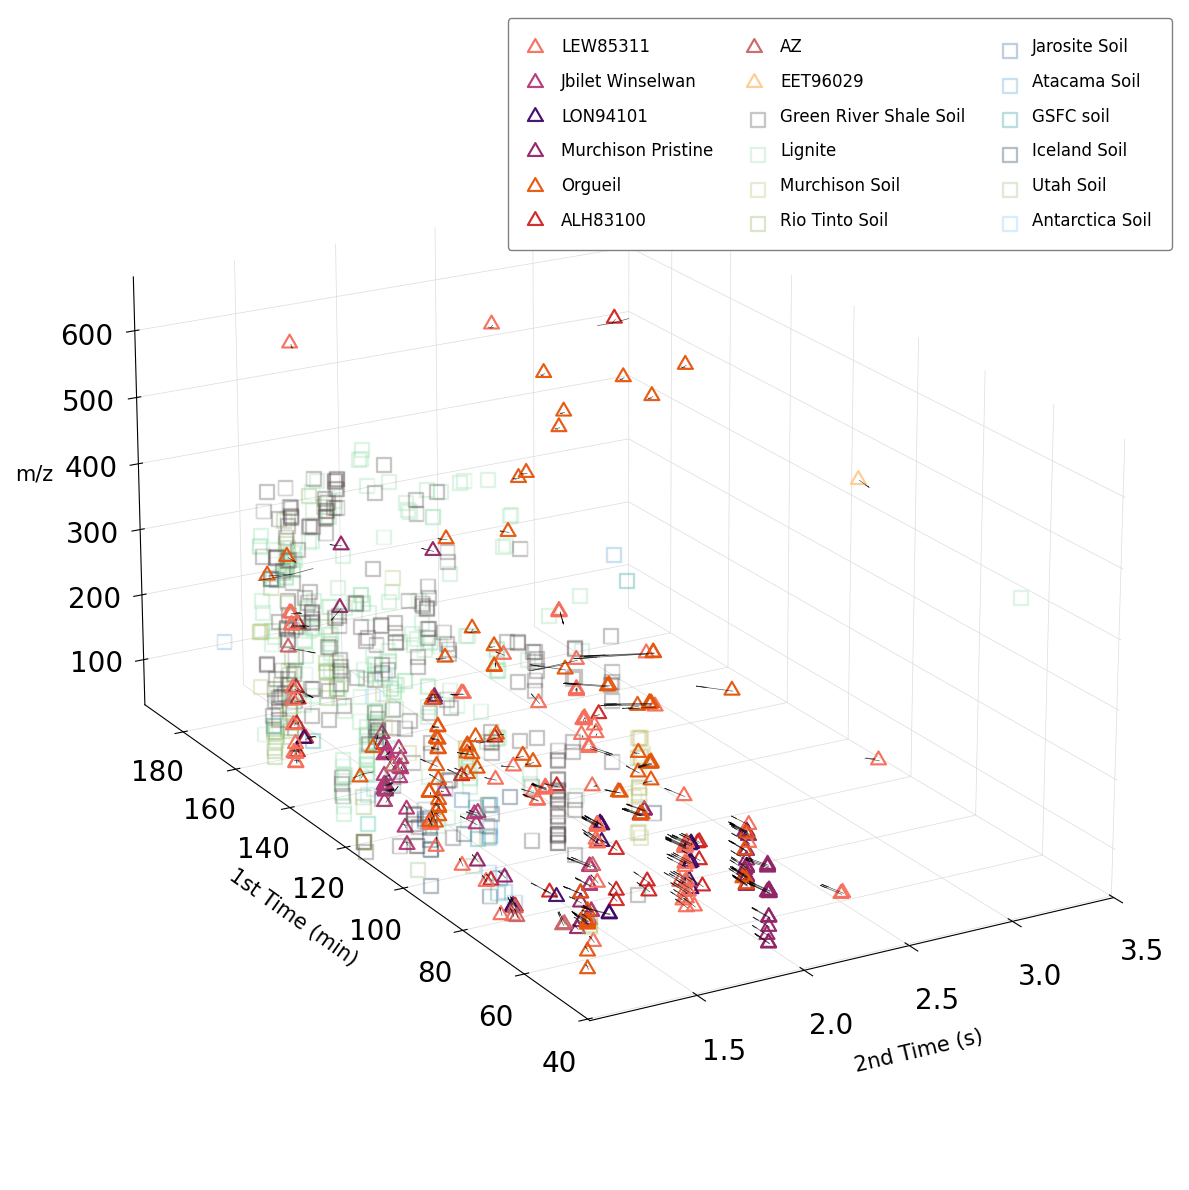

In [56]:
from svgpathtools import svg2paths
from svgpath2mpl import parse_path
import random
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
from matplotlib.markers import MarkerStyle

def get_marker(svg_path):
    cwd = os.getcwd()
    custom_path, attributes = svg2paths(svg_path)
    marker = parse_path(attributes[0]['d'])
    marker.vertices -= marker.vertices.mean(axis=0)
    marker = marker.transformed(mpl.transforms.Affine2D().rotate_deg(180))
    marker = marker.transformed(mpl.transforms.Affine2D().scale(-1,1))
    return marker

def plot_peak_gradients(peaks_features_df, samples, df1, gradients, result_dir, view='small'):
    peaks_features_df = peaks_features_df.copy()

    # Set up markers
    oval = Path([(1,-1), (-1,-1), (-1,1), (1,1), (1,-1)], [Path.MOVETO, Path.CURVE3, Path.LINETO, Path.CURVE3, Path.LINETO])

    hollow_square = get_marker('markers/geometry-shape-square-figure-form-graphic-svgrepo-com.svg')
    triangle_marker = get_marker('markers/triangle-svgrepo-com.svg')

    markers_biotic = [hollow_square]*10
    colors_biotic = ["#595051", "#9be1af", "#c3c378", "#8cb45f", "#366ea5",
                     "#5aa5d7", "#279b91", "#143c55", "#9bbe87", "#82d2f5"]

    markers_abiotic = [triangle_marker]*8
    colors_abiotic = ["#f66e5b","#b53778","#410868","#932467","#e6550c","#d22323","#c86468","#fdcc90"]

    fig = plt.figure(figsize=(24, 24) if view != 'small' else (12, 12))
    ax = fig.add_subplot(111, projection='3d')
    plt.tight_layout()

    # Plot each class
    for class_id, markers, colors in zip([0, 1], [markers_abiotic, markers_biotic], [colors_abiotic, colors_biotic]):
        class_samples = samples[samples['class'] == class_id]['sample_name'].unique()
        for i, sample in enumerate(class_samples):
            sample_df = peaks_features_df[(peaks_features_df['sample_name'] == sample) & (peaks_features_df['class'] == class_id)]
            if class_id == 1:
                alpha = 0.23
                colors = colors_biotic
            else:
                alpha = 0.9
                colors = colors_abiotic
            if class_id == 1:
                size = 200
            else:
                size = 200

            ax.scatter(
                sample_df['RT2_center'],
                sample_df['RT1_center'] / 60.0,
                sample_df['m/z'],
                c=colors[i % len(colors)],
                marker=markers[i % len(markers)],
                s=size,
                alpha=alpha,
                edgecolors=colors[i % len(colors)],
                label=f'{sample}'
            )

    quiver_scale = 5 if view == "small" else 7
    quiver_kwargs = dict(length=quiver_scale, normalize=True, colors="black", linewidth=0.45, edgecolors='k', alpha=0.7)
    ax.quiver(df1['RT2_center'], df1['RT1_center'] / 60.0, df1['m/z'],
              scaled_gradients[:, 1], scaled_gradients[:, 0] / 60.0, scaled_gradients[:, 2],
              **quiver_kwargs)

    # Set labels, ticks, and view
    ax.set_xlabel('2nd Time (s)', labelpad=30, fontsize=15)
    ax.set_ylabel('1st Time (min)', labelpad=30, fontsize=15)
    ax.set_zlabel('m/z', labelpad=30, fontsize=15)

    ax.tick_params(axis='both', which='major', labelsize=20)

    ax.tick_params(axis='x', which='major', pad=15)
    ax.tick_params(axis='y', which='major', pad=15)
    ax.tick_params(axis='z', which='major', pad=15)

    ax.view_init(elev=20, azim=-120 if view == 'small' else -160)
    ax.set_box_aspect([2.5, 4, 2] if view == 'small' else [3, 4, 2])

    plt.gcf().set_facecolor('white')
    plt.gca().set_facecolor('white')
    ax.xaxis._axinfo['grid'].update(color = '#dcdcdc', linestyle = '-' , linewidth=0.5)
    ax.yaxis._axinfo['grid'].update(color = '#dcdcdc', linestyle = '-', linewidth=0.5)
    ax.zaxis._axinfo['grid'].update(color = '#dcdcdc', linestyle = '-', linewidth=0.5)

    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

    ax.legend(handletextpad = 1, fontsize='12', title_fontsize='14', handlelength=1, loc='upper right', borderpad=1.2, labelspacing=1, frameon=True, framealpha=1, edgecolor='gray', facecolor='white', ncol=3)

    ax.set_xlim(peaks_features_df['RT2_center'].min(), 3.5)
    #ax.set_ylim(peaks_features_df['RT1_center'].min(), 190)
    ax.set_zlim(peaks_features_df['m/z'].min(), 680)
    #plt.tight_layout()
    # Uncomment the line below to save the figure
    plt.savefig('peak_gradients_figure.pdf', dpi=300)
    plt.show()
    plt.close()

plot_peak_gradients(df, df, df1, scaled_gradients, '/content/', view='small')

<Axes: >

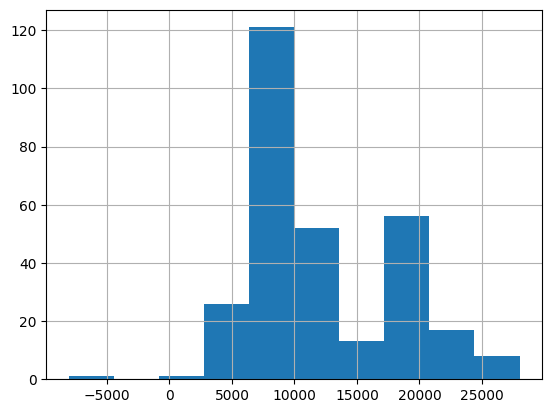

In [68]:
df1['grad_RT1'].hist()

In [10]:
# Function to calculate the gradient of the log PDF at a point
def gradient_log_pdf(point, mean, cov):
    inv_cov = np.linalg.inv(cov)
    return inv_cov @ (point - mean)


def gradient_descent(df):
    df1 = df[df['class'] == 0]
    df2 = df[df['class'] == 1]

    # Create a dataframe including both retention times and mass/charge
    features_all = df[['RT1_center', 'RT2_center', 'm/z']].to_numpy()
    features_class0_ = df1[['RT1_center', 'RT2_center', 'm/z']].to_numpy()
    features_class1_ = df2[['RT1_center', 'RT2_center', 'm/z']].to_numpy()

    # Normalize all features for gradient calculation
    scaler = StandardScaler()
    scaler.fit(features_all)
    features_class0 = scaler.transform(features_class0_)
    features_class1 = scaler.transform(features_class1_)

    # Create a multivariate Gaussian distribution for biotic features
    mean1 = np.mean(features_class1, axis=0)
    cov1 = np.cov(features_class1, rowvar=False)
    dist1 = multivariate_normal(mean=mean1, cov=cov1)

    rt1 = [features_class0_[:, 0]]
    rt2 = [features_class0_[:, 1]]
    mz = [features_class0_[:, 2]]
    grad_rt1 = []
    grad_rt2 = []
    grad_mz = []

    features = features_class0

    # 'Learning' rate - controls how influential gradients are
    alpha = 1

    time_steps = 50
    for t in range(time_steps):
        # Compute gradient and move in that direction
        gradients = np.array([gradient_log_pdf(point, mean1, cov1) for point in features])
        features -= (alpha / ((t + 1)*5)) * gradients

        # Update new feature locations
        rt1.append(features[:, 0] * scaler.scale_[0] + scaler.mean_[0])
        rt2.append(features[:, 1] * scaler.scale_[1] + scaler.mean_[1])
        mz.append(features[:, 2] * scaler.scale_[2] + scaler.mean_[2])

        # Save gradients for later analysis
        grad_rt1.append(gradients[:, 0])
        grad_rt2.append(gradients[:, 1])
        grad_mz.append(gradients[:, 2])

    return rt1, rt2, mz, grad_rt1, grad_rt2, grad_mz

rt1, rt2, mz, grad_rt1, grad_rt2, grad_mz = gradient_descent(df)

array([[<Axes: title={'center': 'grad_RT2'}>]], dtype=object)

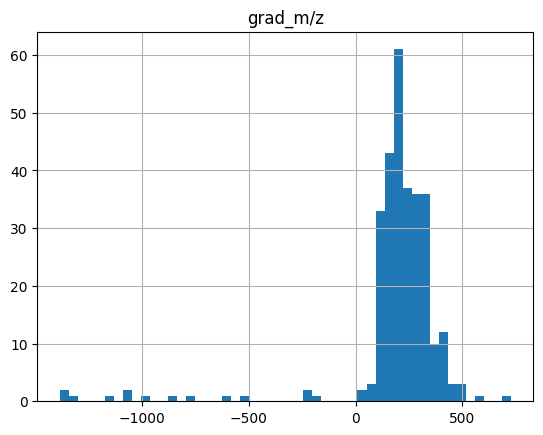

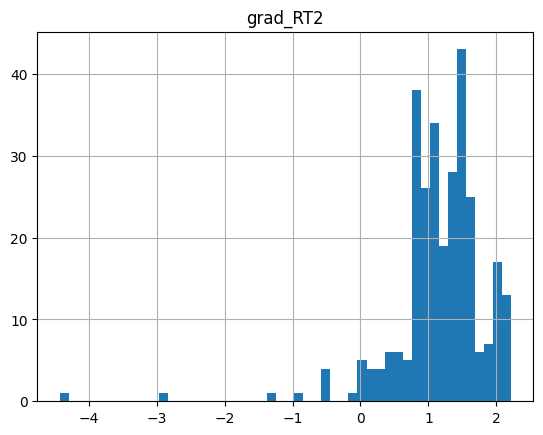

In [29]:
df1.hist(column='grad_m/z', bins=50)
df1.hist(column='grad_RT2', bins=50)